# 009 Filter NDC scenarios 
### Susanne (& Gaurav)

The raw data is from IPCC AR6 WGIII (Riahi et al., 2022; Byers et al., 2022).

In this notebook we filter out scenarios that pass through NDC levels in 2030, irrespective of the climate category that they belong to. We also filter out scenarios that still have increasing CO2-emissions in the last 5 years of the 21st century.

References:

> Riahi, K. et al. Mitigation pathways compatible with long-term goals. in IPCC, 2022: Climate Change 2022: Mitigation of Climate Change. Contribution of Working Group III to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change (eds. Shukla, P. R. et al.) (Cambridge University Press, 2022). doi:10.1017/9781009157926.005.

> Byers, E. et al. AR6 Scenarios Database. (2022) doi:10.5281/zenodo.5886912.

In [1]:
import pyam
import pandas as pd
import numpy as np
import yaml
from pathlib import Path
import scmdata

import utils

<IPython.core.display.Javascript object>

# 1 Filter NDC-scenarios from large AR6 database

## Read in data
The required files: Metadata can be downloaded from the AR6 database; Scenario data was provided by Zebedee Nicholls
* `20211011_ar6emissions_harmonized_infilled.csv`: Scenario data
* `AR6_Scenarios_Database_metadata_indicators_v1.0.xlsx`: Metadata indicators


In [2]:
data_folder = Path('../data/raw/ar6-wg3/')
data_file = Path(data_folder / '20220314_ar6emissions_harmonized_infilled.csv')
meta_file = Path(data_folder / 'AR6_Scenarios_Database_metadata_indicators_v1.0.xlsx')

In [3]:
df_ar6=pyam.IamDataFrame(
    data_file
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/raw/ar6-wg3/20220314_ar6emissions_harmonized_infilled.csv


Now, we load the metadata for the scenarios.

In [4]:
df_ar6.load_meta(
    meta_file,
    sheet_name='meta_Ch3vetted_withclimate'
)

pyam.core - INFO: Reading meta indicators for 1202 out of 1836 scenarios


In [5]:
df_ar6.filter(
    Category='C*',
    inplace=True
)

In [6]:
df_ar6.meta.Policy_category_name.unique()

array(['P2a: Immediate global action without transfers', 'P1a: Baseline',
       'P3b: NDC + Delayed global action', 'P1c: NDC',
       'P3c: Other policies + Delayed global action',
       'P1b: Current policies', 'P2: Immediate global action',
       'P1: Reference (baseline or current policies)',
       'P1d: Other policies',
       'P2c: Other policies + Immediate global action',
       'P3a: Delayed global action',
       'Diagnostic around a delay case through current policies or weaker in 2030',
       'Diagnostic around a delay case through NDCs in 2030',
       'Diagnostic around another limited policy reference case',
       'Diagnostic around no policy baseline',
       'P2b: Immediate global action with transfers',
       'Diagnostic around an immediate action case', 'P0: Diagnostic',
       'P4: Cost-benefit analysis'], dtype=object)

## Pull out NDC type scenarios
To identify the scenarios that pass through the NDC emissions, we look at the following policy categories:
* P3b: 'NDC + Delayed global action'
* P1c: 'NDC'
* P0_3b: 'Diagnostic around a delay case through NDCs in 2030'

In [7]:
df_ar6_ndc_vars=df_ar6.filter(
    Policy_category=[
        'P3b',
        'P1c',
        'P0_3b'
    ]
)

In [8]:
# export as new .csv file

df_ar6_ndc_vars.to_csv(
    Path(data_folder / 'ar6emissions_ndc_snapshot.csv')
)

Plot to see if it looks ok.

/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot: title={'center': 'region: World - variable: AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes'}, xlabel='Time', ylabel='Mt CO2/yr'>

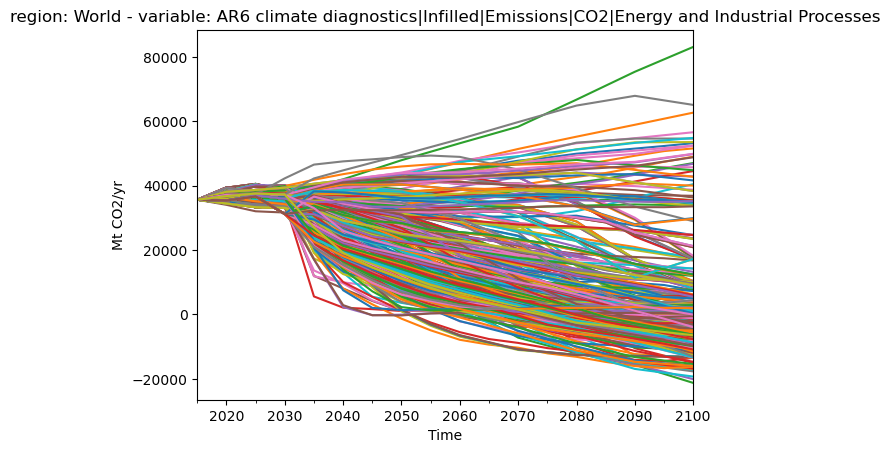

In [9]:
df_ar6_ndc_vars.filter(
    variable='AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes'
).plot()

# 2 Remove scenarios that still ahve increasing emissions in 2090-2100

In [10]:
# Create an aggregate CO2 variable
df_ar6_total_cdr = df_ar6_ndc_vars.aggregate(
    variable='AR6 climate diagnostics|Infilled|Emissions|CO2|both',
    components=[
        'AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes',
        'AR6 climate diagnostics|Infilled|Emissions|CO2|AFOLU'
    ]
)

In [11]:
### filter net-zero pathways (write exlcude = True in metadata)
df_ar6_total_cdr.validate(criteria={'AR6 climate diagnostics|Infilled|Emissions|CO2|both': {'up': 0, 'year': 2100}}, exclude_on_fail=True)

pyam.core - INFO: 161 of 32594 data points do not satisfy the criteria
pyam.core - INFO: 161 non-valid scenarios will be excluded


,model,scenario,region,variable,unit,time,value
0,AIM/CGE 2.1,CD-LINKS_INDC2030i_1600,World,AR6 climate diagnostics|Infilled|Emissions|CO2...,Mt CO2/yr,2100-01-01,6025.833919
1,AIM/CGE 2.1,CD-LINKS_INDCi,World,AR6 climate diagnostics|Infilled|Emissions|CO2...,Mt CO2/yr,2100-01-01,51532.993007
2,AIM/CGE 2.2,EN_INDCi2030_1200,World,AR6 climate diagnostics|Infilled|Emissions|CO2...,Mt CO2/yr,2100-01-01,83.260148
3,AIM/CGE 2.2,EN_INDCi2030_1400,World,AR6 climate diagnostics|Infilled|Emissions|CO2...,Mt CO2/yr,2100-01-01,83.293848
4,AIM/CGE 2.2,EN_INDCi2030_1600,World,AR6 climate diagnostics|Infilled|Emissions|CO2...,Mt CO2/yr,2100-01-01,83.309248
...,...,...,...,...,...,...,...
156,WITCH 5.0,EN_INDCi2030_3000f,World,AR6 climate diagnostics|Infilled|Emissions|CO2...,Mt CO2/yr,2100-01-01,31645.565687
157,WITCH 5.0,EN_INDCi2030_3000f_NDCp,World,AR6 climate diagnostics|Infilled|Emissions|CO2...,Mt CO2/yr,2100-01-01,31979.063524
158,WITCH 5.0,EN_INDCi2100,World,AR6 climate diagnostics|Infilled|Emissions|CO2...,Mt CO2/yr,2100-01-01,35612.887825
159,WITCH 5.0,EN_INDCi2100_NDCp,World,AR6 climate diagnostics|Infilled|Emissions|CO2...,Mt CO2/yr,2100-01-01,32834.666748


In [12]:
net_zero = df_ar6_total_cdr.filter(exclude=False)

/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot: title={'center': 'region: World - variable: AR6 climate diagnostics|Infilled|Emissions|CO2|both'}, xlabel='Time', ylabel='Mt CO2/yr'>

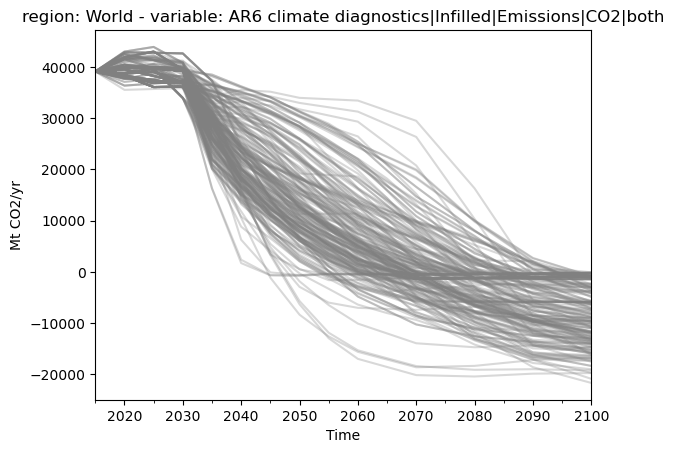

In [13]:
net_zero.filter(variable='AR6 climate diagnostics|Infilled|Emissions|CO2|both').plot(color = 'gray', alpha = 0.3)

In [14]:
# get those scenarios that are not zero and filter out those that still have increasing emissions
above_zero = df_ar6_total_cdr.filter(exclude=True)
# calculate difference between 2095 and 2100 -> use this as indicator for whether emissions are still increasing
above_zero.diff({'AR6 climate diagnostics|Infilled|Emissions|CO2|both':'diff'},
               periods=5, append=True)
# reset exclude-meta
above_zero.set_meta(False, name='exclude')
# set values with not decreasing emissions to True in meta
above_zero.validate(criteria={'diff': {'up': 0, 'year': 2100}},exclude_on_fail=True)
# select only decreasing pathways
sel_above = above_zero.filter(exclude=False)

pyam.core - INFO: 24 of 26887 data points do not satisfy the criteria
pyam.core - INFO: 24 non-valid scenarios will be excluded


In [15]:
# combine net-zero datset with decreasing emissions dataset
sel_above.append(
        net_zero,
    inplace = True
)

In [16]:
def create_ms_col(df):
    # run datset with only relevant scenarios
    scm_df = scmdata.ScmRun(df.timeseries())
    # create new column with combined model&scenario info
    scm_df['ms']=scm_df['model']+scm_df['scenario']
    # list of combined model&scenario info of net_zero pathways
    scenarios_list = scm_df.get_unique_meta('ms')
    return scm_df, scenarios_list

# run the filtered scens
relevant_scenarios_scm, relevant_scenarios_list = create_ms_col(sel_above)
# run the raw dataset 
df_ar6_ndc_vars_scm, df_ar6_ndc_vars_list = create_ms_col(df_ar6_ndc_vars)

In [17]:
# of the raw dataset filter out only the relevant scenarios
df_ar6_ndc_relevant = df_ar6_ndc_vars_scm.filter(ms=relevant_scenarios_list)

In [18]:
df_ar6_ndc_relevant.to_csv(Path(data_folder / 'ar6emissions_ndc_relscenarios.csv'))

Plot to check final result

/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/plotting.py:96: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


<AxesSubplot: xlabel='time', ylabel='Mt CO2/yr'>

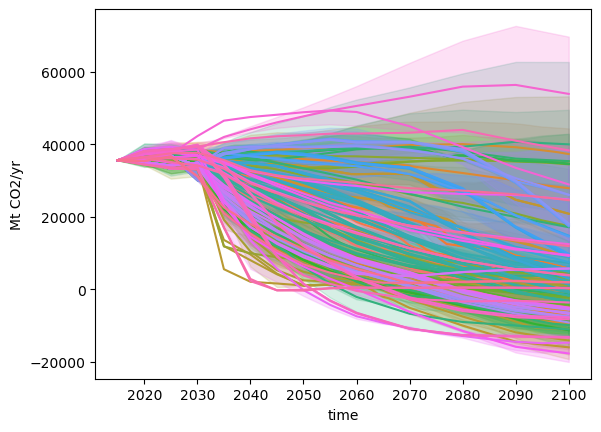

In [21]:
df_ar6_ndc_relevant.filter(
    variable='AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes'
).lineplot(legend=False)